## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

## Properly store images 

When you're analyzing your image data, file management is important. We will be using the santa images again, but this time, they are stored in two folders: `normal` and `pneumonia`. We want to work with a `train`, `validation`, and `test` datasets now, as we know by now that this is the best way to obtain unbiased estimate of your model performance.  

Below we create three objects representing the existing directories: `data/PNEUMONIA` as `data_pneumonia_dir` and `data/NORMAL` as `data_normal_dir`. We will create a new directory `split/` as `new_dir`, where we will split the dataset in three groups (or three subdirectories): `train`, `test`, and `validation`, each containing `PNEUMONIA` and `NORMAL` subfolders.

In [2]:
# Load the images; be sure to also preprocess these into tensors 
data_pneumonia_dir = 'data/PNEUMONIA/'
data_normal_dir = 'data/NORMAL/'
new_dir = 'split/'

Let's print out how many images we have in each directory so we know for sure our numbers are right!

In [3]:
imgs_pneumonia = [file for file in os.listdir(data_pneumonia_dir) if file.endswith('.jpeg')]
print('There are', len(imgs_pneumonia), ' PNEUMONIA images')

There are 4273  PNEUMONIA images


In [4]:
imgs_pneumonia[0:10]

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg',
 'person1005_bacteria_2936.jpeg',
 'person1005_virus_1688.jpeg']

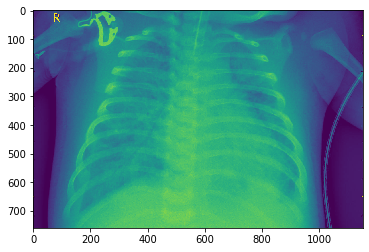

In [5]:
img = mpimg.imread(data_pneumonia_dir+imgs_pneumonia[0])
imgplot = plt.imshow(img)
plt.show()

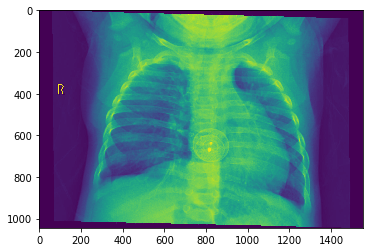

In [6]:
img = mpimg.imread(data_pneumonia_dir+imgs_pneumonia[10])
imgplot = plt.imshow(img)
plt.show()

In [7]:
imgs_normal = [file for file in os.listdir(data_normal_dir) if file.endswith('.jpeg')]
print('There are', len(imgs_normal), ' NORMAL images for training')

There are 1583  NORMAL images for training


In [8]:
imgs_normal[0:10]

['IM-0001-0001.jpeg',
 'IM-0003-0001.jpeg',
 'IM-0005-0001.jpeg',
 'IM-0006-0001.jpeg',
 'IM-0007-0001.jpeg',
 'IM-0009-0001.jpeg',
 'IM-0010-0001.jpeg',
 'IM-0011-0001-0001.jpeg',
 'IM-0011-0001-0002.jpeg',
 'IM-0011-0001.jpeg']

Create all the folders and subfolders in order to get the structure represented above. You can use `os.path.join()` to create strings that will be used later on to generate new directories.

In [9]:
if os.path.isdir(new_dir) == False:
    os.mkdir(new_dir)

In [10]:
train_folder = os.path.join(new_dir, 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join(new_dir, 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join(new_dir, 'validation')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [11]:
train_pneumonia

'split/train/PNEUMONIA'

Now use all the path strings you created to make new directories. You can use `os.mkdir()` to do this. Go have a look at your directory and see if this worked!

In [12]:
# testing folder
if os.path.isdir(test_folder) == False:
    os.mkdir(test_folder)
if os.path.isdir(test_pneumonia) == False:
    os.mkdir(test_pneumonia)
if os.path.isdir(test_normal) == False:
    os.mkdir(test_normal)

# training folder    
if os.path.isdir(train_folder) == False:
    os.mkdir(train_folder)
if os.path.isdir(train_pneumonia) == False:
    os.mkdir(train_pneumonia)
if os.path.isdir(train_normal) == False:
    os.mkdir(train_normal)

# validating folder
if os.path.isdir(val_folder) == False:
    os.mkdir(val_folder)
if os.path.isdir(val_pneumonia) == False:
    os.mkdir(val_pneumonia)
if os.path.isdir(val_normal) == False:  
    os.mkdir(val_normal)

Copy X-ray chest images in three subfolders. Let's put images in training, validation and testing sets, respectively.

* training

for the `PNEUMONIA` images!

In [13]:
# training data of pneumonia
imgs = imgs_pneumonia[:3418]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(train_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

Now, repeat all this for the `NORMAL` images!

In [14]:
# training data of normal
imgs = imgs_normal[:1267]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(train_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

* testing

for the `PNEUMONIA` images!

In [15]:
# testing data of pneumonia
imgs = imgs_pneumonia[3418:3845]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(test_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

Now, repeat all this for the `NORMAL` images!

In [16]:
# testing data of normal
imgs = imgs_normal[1267:1425]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(test_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

* validating

for the `PNEUMONIA` images!

In [17]:
# validating data of pneumonia
imgs = imgs_pneumonia[3845:4273]
for img in imgs:
    origin = os.path.join(data_pneumonia_dir, img)
    destination = os.path.join(val_pneumonia, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

Now, repeat all this for the `NORMAL` images!

In [18]:
# validating data of normal
imgs = imgs_normal[1425:1583]
for img in imgs:
    origin = os.path.join(data_normal_dir, img)
    destination = os.path.join(val_normal, img)
    if os.path.isfile(destination) == False:
        shutil.copyfile(origin, destination)

In [19]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(150, 150), batch_size = 4685)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [20]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(150, 150), batch_size = 585)
    #,
    #class_mode='binary')

validating data:
Found 586 images belonging to 2 classes.


In [21]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(150, 150), batch_size = 585)
    #,
    #class_mode='binary') 

testing data:
Found 585 images belonging to 2 classes.


In [22]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

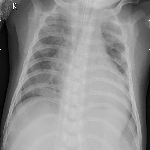

In [23]:
array_to_img(train_images[0])

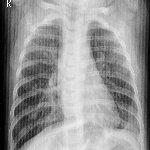

In [24]:
array_to_img(train_images[10])

In [25]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("*******************************************")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("*******************************************")
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("*******************************************")
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("*******************************************")

Number of training samples: 4685
Number of testing samples: 585
Number of validation samples: 585
*******************************************
train_images shape: (4685, 150, 150, 3)
train_labels shape: (4685, 2)
*******************************************
test_images shape: (585, 150, 150, 3)
test_labels shape: (585, 2)
*******************************************
val_images shape: (585, 150, 150, 3)
val_labels shape: (585, 2)
*******************************************


In [26]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4685, 67500)
(585, 67500)
(585, 67500)


In [27]:
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(4685, 2)
(585, 2)
(585, 2)


In [28]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [29]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [30]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(4685, 1)
(585, 1)
(585, 1)


## Use a densely connected network as a baseline

Now that we've a handle on our data, we can easily use Keras' module with image-processing tools. Let's import the necessary libraries below. 

In [31]:
# Build a baseline fully connected model
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1350020   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,350,213
Trainable params: 1,350,213
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
print('program starts, current time:')
print(start)
histoire = model.fit(train_img, train_y, epochs=40, batch_size=100, validation_data=(val_img, val_y))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-09-18 07:01:17.492781
Epoch 1/40
47/47 [==============================] - 7s 145ms/step - loss: 0.5825 - accuracy: 0.7274 - val_loss: 0.5388 - val_accuracy: 0.7299
Epoch 2/40
47/47 [==============================] - 4s 75ms/step - loss: 0.4787 - accuracy: 0.7526 - val_loss: 0.4060 - val_accuracy: 0.7778
Epoch 3/40
47/47 [==============================] - 3s 74ms/step - loss: 0.4602 - accuracy: 0.7827 - val_loss: 0.3740 - val_accuracy: 0.8068
Epoch 4/40
47/47 [==============================] - 3s 72ms/step - loss: 0.3825 - accuracy: 0.8386 - val_loss: 0.4318 - val_accuracy: 0.8598
Epoch 5/40
47/47 [==============================] - 3s 74ms/step - loss: 0.3655 - accuracy: 0.8604 - val_loss: 0.5353 - val_accuracy: 0.7761
Epoch 6/40
47/47 [==============================] - 3s 71ms/step - loss: 0.3481 - accuracy: 0.8732 - val_loss: 0.3265 - val_accuracy: 0.8718
Epoch 7/40
47/47 [==============================] - 3s 73ms/step - loss: 0.3419 - accuracy: 0.87

## Baseline Model Evaluation

Now use the test set to perform an evaluation on the model of choice. 

In [35]:
results_train = model.evaluate(train_img, train_y)

147/147 [==============================] - 2s 13ms/step - loss: 0.2137 - accuracy: 0.9311


In [36]:
results_test = model.evaluate(test_img, test_y)

19/19 [==============================] - 1s 35ms/step - loss: 0.1858 - accuracy: 0.9470


In [37]:
results_train

[0.21374578773975372, 0.931056559085846]

In [38]:
results_test

[0.18582329154014587, 0.9470085501670837]

In [39]:
histoire.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

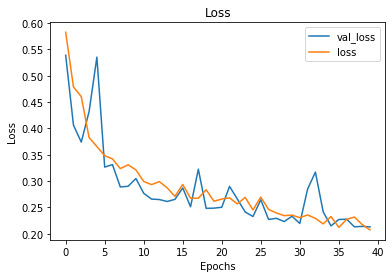

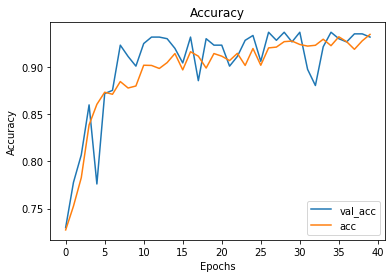

In [41]:
visualize_training_results(histoire)

## Saving baseline Model

Note: early stopping is introduced from Sep. 16th, 2020 (to avoid model training from over-fitting)
epoch number is changed from 100 down to 42

In [42]:
model.save('baseline_chest_xray_ALL_data_'+str(date.today())+'.h5')

## Saving history in CSV

In [43]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(histoire.history) 
# or save to csv: 
hist_csv_file = 'baseline_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Designing CNN Model

Now it's time to design your CNN using Keras! Remember a few things when doing this: 

- You should alternate convolutional and pooling layers
- You should have later layers have a larger number of parameters in order to detect more abstract patterns
- Add some final dense layers to add a classifier to the convolutional base 
- Compile this model 

In [44]:
# Your code here; design and compile the model
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

## Training and Evaluating the Model

Remember that training deep networks is resource intensive: depending on the size of the data, even a CNN with 3-4 successive convolutional and pooling layers is apt to take hours to train on a high-end laptop. Using 30 epochs and 8 layers (alternating between convolutional and pooling), my model took about 14 hours to run on a 9 years old macbook pro (Late 2011, macOS High Sierra, v.10.13.6). That is, I set my model to run the training epochs overnight.  

In [46]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start2 = datetime.datetime.now()
print('program starts, current time:')
print(start2)
history = model2.fit(train_images, train_y, epochs=40, batch_size=100, validation_data=(val_images, val_y))
end2 = datetime.datetime.now()
print('program ends, current time:')
print(end2)
elapsed2 = end2 - start2
print('Training took a total of {}'.format(elapsed2))

program starts, current time:
2020-09-18 07:11:33.230978
Epoch 1/40
47/47 [==============================] - 398s 8s/step - loss: 0.5301 - accuracy: 0.7422 - val_loss: 0.7225 - val_accuracy: 0.4923
Epoch 2/40
47/47 [==============================] - 424s 9s/step - loss: 0.3747 - accuracy: 0.8335 - val_loss: 0.3385 - val_accuracy: 0.8427
Epoch 3/40
47/47 [==============================] - 431s 9s/step - loss: 0.2794 - accuracy: 0.8867 - val_loss: 0.2295 - val_accuracy: 0.9094
Epoch 4/40
47/47 [==============================] - 447s 10s/step - loss: 0.2289 - accuracy: 0.9110 - val_loss: 0.4432 - val_accuracy: 0.8188
Epoch 5/40
47/47 [==============================] - 443s 9s/step - loss: 0.2018 - accuracy: 0.9197 - val_loss: 0.1870 - val_accuracy: 0.9316
Epoch 6/40
47/47 [==============================] - 446s 9s/step - loss: 0.1710 - accuracy: 0.9349 - val_loss: 0.1678 - val_accuracy: 0.9368
Epoch 7/40
47/47 [==============================] - 445s 9s/step - loss: 0.1674 - accuracy: 0.93

## CNN Model Evaluation

Now use the test set to perform an evaluation on the model of choice. 

In [47]:
results2_train = model2.evaluate(train_images, train_y)

147/147 [==============================] - 136s 926ms/step - loss: 0.0283 - accuracy: 0.9917


In [48]:
results2_test = model2.evaluate(test_images, test_y)

19/19 [==============================] - 16s 858ms/step - loss: 0.1335 - accuracy: 0.9641


In [49]:
results2_train

[0.02829151786863804, 0.9916755557060242]

In [50]:
results2_test

[0.1334575116634369, 0.964102566242218]

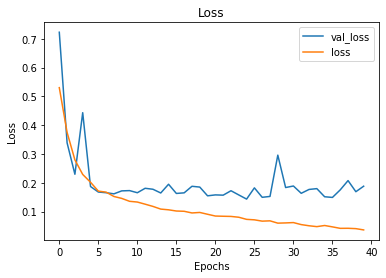

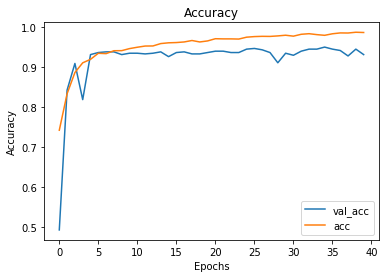

In [51]:
visualize_training_results(history)

## Saving CNN Model

In [52]:
# Your code here; save the model for future reference 
model2.save('cnn1_chest_xray_ALL_data_'+str(date.today())+'.h5')

## Saving history in CSV

In [53]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Learning rate tuning 

In [54]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

In [55]:
model4.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [56]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start4 = datetime.datetime.now()
print('program starts, current time:')
print(start4)
history3 = model4.fit(train_images, train_y, epochs=40, batch_size=100, validation_data=(val_images, val_y))
end4 = datetime.datetime.now()
print('program ends, current time:')
print(end4)
elapsed4 = end4 - start4
print('Training took a total of {}'.format(elapsed4))

program starts, current time:
2020-09-18 12:34:54.787845
Epoch 1/40
47/47 [==============================] - 463s 10s/step - loss: 0.5704 - accuracy: 0.7296 - val_loss: 0.5534 - val_accuracy: 0.7299
Epoch 2/40
47/47 [==============================] - 459s 10s/step - loss: 0.5025 - accuracy: 0.7385 - val_loss: 0.4846 - val_accuracy: 0.8786
Epoch 3/40
47/47 [==============================] - 478s 10s/step - loss: 0.4233 - accuracy: 0.8075 - val_loss: 0.3944 - val_accuracy: 0.8957
Epoch 4/40
47/47 [==============================] - 495s 11s/step - loss: 0.3547 - accuracy: 0.8619 - val_loss: 0.3333 - val_accuracy: 0.8564
Epoch 5/40
47/47 [==============================] - 493s 10s/step - loss: 0.3116 - accuracy: 0.8805 - val_loss: 0.2939 - val_accuracy: 0.9043
Epoch 6/40
47/47 [==============================] - 468s 10s/step - loss: 0.2831 - accuracy: 0.8892 - val_loss: 0.2731 - val_accuracy: 0.9145
Epoch 7/40
47/47 [==============================] - 472s 10s/step - loss: 0.2595 - accuracy

In [57]:
results4_train = model4.evaluate(train_images, train_y)

147/147 [==============================] - 132s 898ms/step - loss: 0.1345 - accuracy: 0.9505


In [58]:
results4_test = model4.evaluate(test_images, test_y)

19/19 [==============================] - 16s 833ms/step - loss: 0.1050 - accuracy: 0.9624


In [59]:
results4_train

[0.13448919355869293, 0.9504802823066711]

In [60]:
results4_test

[0.10501779615879059, 0.9623931646347046]

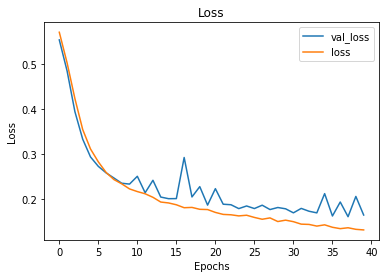

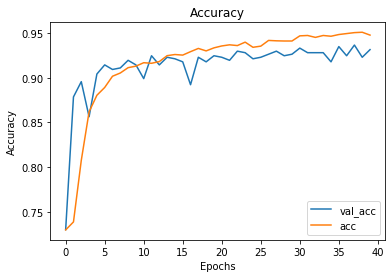

In [61]:
visualize_training_results(history3)

In [62]:
# Your code here; save the model for future reference 
model4.save('cnn1_chest_xray_ALL_data_LearningRate_Tuning_'+str(date.today())+'.h5')

In [63]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history3.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_ALL_data_LearningRate_Tuning'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Comparing Models

* accuracy history plot for densely connected network (baseline) and convolutional neural network 

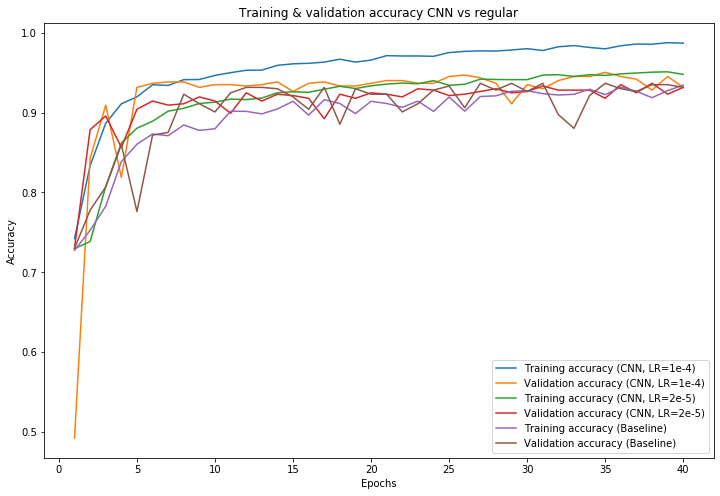

In [81]:
# CNN model details
cnn1_dict = history.history
cnn1_acc_values = cnn1_dict['accuracy'] 
cnn1_val_acc_values = cnn1_dict['val_accuracy']

# Baseline model
baseline_model_dict = histoire.history
baseline_model_acc = baseline_model_dict['accuracy'] 
baseline_model_val_acc = baseline_model_dict['val_accuracy']

# CNN model details (smaller learning rate, aka: LR)
cnn1_finerLR_dict = history3.history
cnn1_finerLR_acc_values = cnn1_finerLR_dict['accuracy'] 
cnn1_finerLR_val_acc_values = cnn1_finerLR_dict['val_accuracy']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(baseline_model_acc) + 1)
ax.plot(epochs, cnn1_acc_values, label='Training accuracy (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_val_acc_values, label='Validation accuracy (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_finerLR_acc_values, label='Training accuracy (CNN, LR=2e-5)')
ax.plot(epochs, cnn1_finerLR_val_acc_values, label='Validation accuracy (CNN, LR=2e-5)')
ax.plot(epochs, baseline_model_acc, label='Training accuracy (Baseline)')
ax.plot(epochs, baseline_model_val_acc, label='Validation accuracy (Baseline)')
ax.set_title('Training & validation accuracy CNN vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

* loss history plot for densely connected network (baseline) and convolutional neural network 

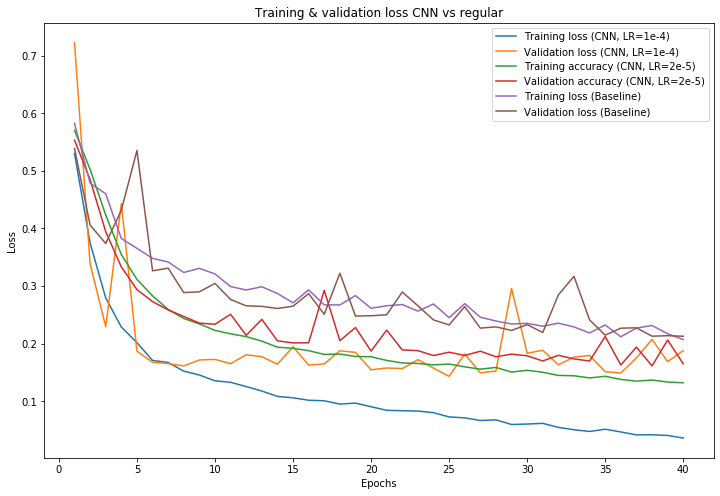

In [82]:
# CNN model details
cnn1_dict = history.history
cnn1_loss_values = cnn1_dict['loss'] 
cnn1_val_loss_values = cnn1_dict['val_loss']

# Baseline model
baseline_model_dict = histoire.history
baseline_model_loss = baseline_model_dict['loss'] 
baseline_model_val_loss = baseline_model_dict['val_loss']

# CNN model details (smaller learning rate, aka: LR)
cnn1_finerLR_dict = history3.history
cnn1_finerLR_loss_values = cnn1_finerLR_dict['loss'] 
cnn1_finerLR_val_loss_values = cnn1_finerLR_dict['val_loss']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(baseline_model_loss) + 1)
ax.plot(epochs, cnn1_loss_values, label='Training loss (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_val_loss_values, label='Validation loss (CNN, LR=1e-4)')
ax.plot(epochs, cnn1_finerLR_loss_values, label='Training accuracy (CNN, LR=2e-5)')
ax.plot(epochs, cnn1_finerLR_val_loss_values, label='Validation accuracy (CNN, LR=2e-5)')
ax.plot(epochs, baseline_model_loss, label='Training loss (Baseline)')
ax.plot(epochs, baseline_model_val_loss, label='Validation loss (Baseline)')
ax.set_title('Training & validation loss CNN vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

## Zooming images

In [66]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(210, 210), batch_size = 4685)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [67]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary')

validating data:
Found 586 images belonging to 2 classes.


In [68]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(210, 210), batch_size = 585)
    #,
    #class_mode='binary') 

testing data:
Found 585 images belonging to 2 classes.


In [69]:
# create the data sets
train_images2, train_labels2 = next(train_generator2)
test_images2, test_labels2 = next(test_generator2)
val_images2, val_labels2 = next(val_generator2)

In [70]:
train_y2 = np.reshape(train_labels2[:,0], (train_labels2.shape[0],1))
test_y2 = np.reshape(test_labels2[:,0], (test_labels2.shape[0],1))
val_y2 = np.reshape(val_labels2[:,0], (val_labels2.shape[0],1))

In [71]:
# Your code here; design and compile the model
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(210, 210, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [72]:
model3.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [73]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start3 = datetime.datetime.now()
print('program starts, current time:')
print(start3)
history2 = model3.fit(train_images2, train_y2, epochs=40, batch_size=100, validation_data=(val_images2, val_y2))
end3 = datetime.datetime.now()
print('program ends, current time:')
print(end3)
elapsed3 = end3 - start3
print('Training took a total of {}'.format(elapsed3))

program starts, current time:
2020-09-18 17:56:36.368959
Epoch 1/40
47/47 [==============================] - 972s 21s/step - loss: 0.5602 - accuracy: 0.7315 - val_loss: 0.5189 - val_accuracy: 0.7624
Epoch 2/40
47/47 [==============================] - 988s 21s/step - loss: 0.4623 - accuracy: 0.7801 - val_loss: 0.4673 - val_accuracy: 0.7316
Epoch 3/40
47/47 [==============================] - 1047s 22s/step - loss: 0.3773 - accuracy: 0.8433 - val_loss: 0.3344 - val_accuracy: 0.8632
Epoch 4/40
47/47 [==============================] - 1070s 23s/step - loss: 0.3146 - accuracy: 0.8800 - val_loss: 0.2860 - val_accuracy: 0.9145
Epoch 5/40
47/47 [==============================] - 998s 21s/step - loss: 0.2704 - accuracy: 0.9010 - val_loss: 0.4110 - val_accuracy: 0.8291
Epoch 6/40
47/47 [==============================] - 983s 21s/step - loss: 0.2416 - accuracy: 0.9114 - val_loss: 0.2429 - val_accuracy: 0.9111
Epoch 7/40
47/47 [==============================] - 965s 21s/step - loss: 0.2261 - accura

In [74]:
results3_train = model3.evaluate(train_images2, train_y2)

147/147 [==============================] - 246s 2s/step - loss: 0.0984 - accuracy: 0.9641


In [75]:
results3_test = model3.evaluate(test_images2, test_y2)

19/19 [==============================] - 29s 2s/step - loss: 0.0798 - accuracy: 0.9726


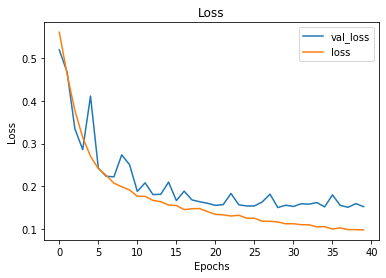

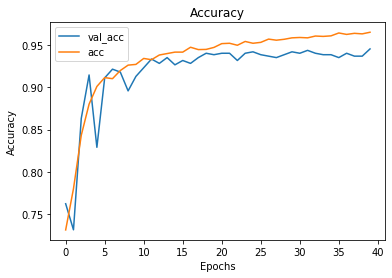

In [76]:
visualize_training_results(history2)

In [77]:
# Your code here; save the model for future reference 
model3.save('cnn1_bigger_chest_xray_ALL_data_'+str(date.today())+'.h5')

In [78]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history2.history) 
# or save to csv: 
hist_csv_file = 'cnn1_bigger_chest_xray_ALL_data'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

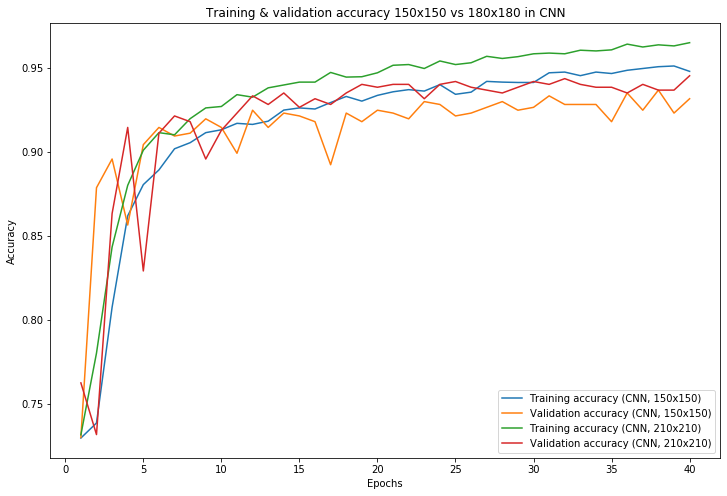

In [85]:
# CNN model details
cnn1_dict = history3.history
cnn1_acc_values = cnn1_dict['accuracy'] 
cnn1_val_acc_values = cnn1_dict['val_accuracy']

# Baseline model
cnn1_bigger_dict = history2.history
cnn1_bigger_acc = cnn1_bigger_dict['accuracy'] 
cnn1_bigger_val_acc = cnn1_bigger_dict['val_accuracy']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(cnn1_acc_values) + 1)
ax.plot(epochs, cnn1_acc_values, label='Training accuracy (CNN, 150x150)')
ax.plot(epochs, cnn1_val_acc_values, label='Validation accuracy (CNN, 150x150)')
ax.plot(epochs, cnn1_bigger_acc, label='Training accuracy (CNN, 210x210)')
ax.plot(epochs, cnn1_bigger_val_acc, label='Validation accuracy (CNN, 210x210)')
ax.set_title('Training & validation accuracy 150x150 vs 180x180 in CNN')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

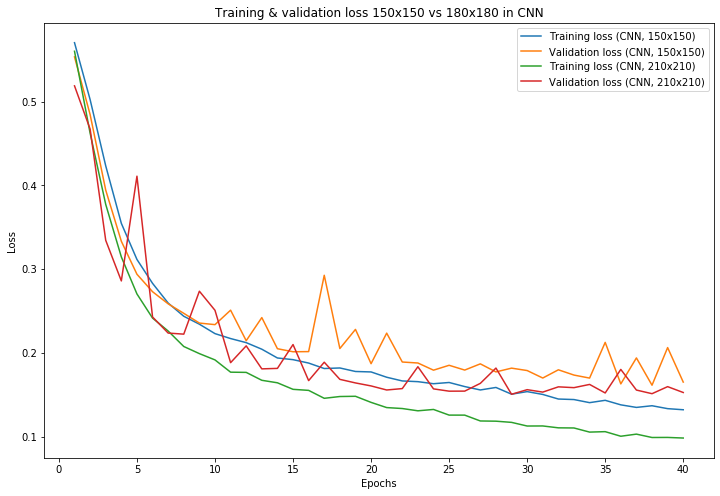

In [87]:
# CNN model details
cnn1_dict = history3.history
cnn1_loss_values = cnn1_dict['loss'] 
cnn1_val_loss_values = cnn1_dict['val_loss']

# Baseline model
cnn1_bigger_dict = history2.history
cnn1_bigger_loss = cnn1_bigger_dict['loss'] 
cnn1_bigger_val_loss = cnn1_bigger_dict['val_loss']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(cnn1_loss_values) + 1)
ax.plot(epochs, cnn1_loss_values, label='Training loss (CNN, 150x150)')
ax.plot(epochs, cnn1_val_loss_values, label='Validation loss (CNN, 150x150)')
ax.plot(epochs, cnn1_bigger_loss, label='Training loss (CNN, 210x210)')
ax.plot(epochs, cnn1_bigger_val_loss, label='Validation loss (CNN, 210x210)')
ax.set_title('Training & validation loss 150x150 vs 180x180 in CNN')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();